species: ['Z', 'X', 'complex_Y_2x_Z_', 'complex_X_2x_Y_Z_', 'complex_X_Y_2x_Z_', 'Y', 'complex_X_2x_Z_', 'complex_X_2x_', 'complex_Y_2x_']

original system:

dZ/dt = -Z*complex_X_2x_*kb__ - Z*complex_Y_2x_*kb__ + complex_X_2x_Z_*ku__ + complex_Y_2x_Z_*ku__
dX/dt = -2.0*X**2*kb__ - X*complex_Y_2x_Z_*kb__ + 2.0*complex_X_2x_*ku__ + complex_X_Y_2x_Z_*ku__
dcomplex_Y_2x_Z_/dt = -X*complex_Y_2x_Z_*kb__ + Z*complex_Y_2x_*kb__ + complex_X_Y_2x_Z_*ku__ - complex_Y_2x_Z_*ku__
dcomplex_X_2x_Y_Z_/dt = Y*complex_X_2x_Z_*kb__ - complex_X_2x_Y_Z_*ku__
dcomplex_X_Y_2x_Z_/dt = X*complex_Y_2x_Z_*kb__ - complex_X_Y_2x_Z_*ku__
dY/dt = -2.0*Y**2*kb__ - Y*complex_X_2x_Z_*kb__ + complex_X_2x_Y_Z_*ku__ + 2.0*complex_Y_2x_*ku__
dcomplex_X_2x_Z_/dt = -Y*complex_X_2x_Z_*kb__ + Z*complex_X_2x_*kb__ + complex_X_2x_Y_Z_*ku__ - complex_X_2x_Z_*ku__
dcomplex_X_2x_/dt = X**2*kb__ - Z*complex_X_2x_*kb__ - complex_X_2x_*ku__ + complex_X_2x_Z_*ku__
dcomplex_Y_2x_/dt = Y**2*kb__ - Z*complex_Y_2x_*kb__ - complex_Y_2x_*ku_

<Figure size 700x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Output Concentration')

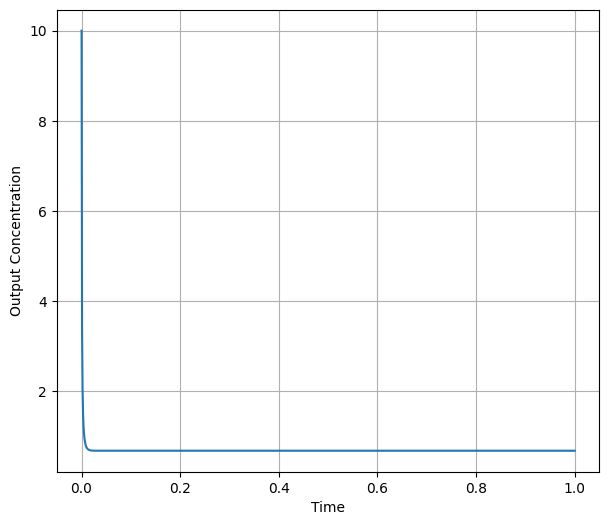

<Figure size 700x600 with 0 Axes>

Text(0.5, 0, 'Time')

Text(0, 0.5, 'Output Concentration')

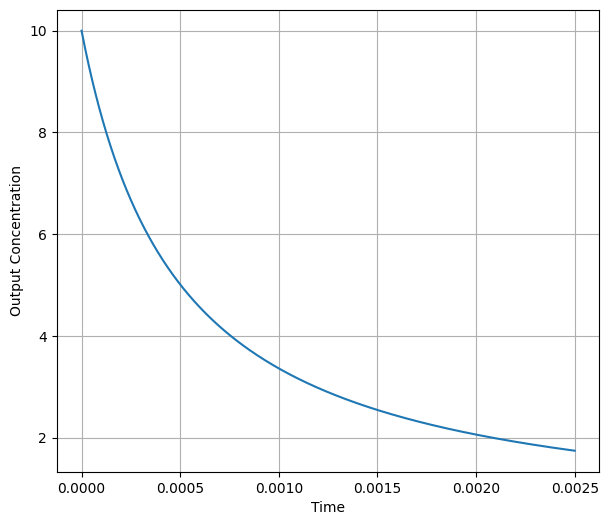

In [196]:
from autoreduce.converters import load_sbml
from sympy import Symbol
import numpy as np

# Load the CRN
sys = load_sbml("example.xml", outputs = "X")

# Set initial conditions
x0_dict = {"X": 10}
for x, x_ic in x0_dict.items():
    curr_ind = sys.x.index(Symbol(x))
    sys.x_init[curr_ind] = x_ic


# Print species
print("species:", [str(s) for s in sys.x])

# Print original system ODEs
print("\noriginal system:\n")
for i, eq in enumerate(sys.f):
    print(f"d{sys.x[i]}/dt = {eq}")

from autoreduce.utils import get_ODE
import matplotlib.pyplot as plt 
import numpy as np 

species_names = [str(s) for s in sys.x]

timepoints2_ode = np.linspace(0,1,1000)
sys_ode = get_ODE(sys, timepoints2_ode)  # sys_ode is the object that we get after using the get_ODE function
sol = sys_ode.solve_system().T  

plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints2_ode, full_model)
plt.xlabel('Time')
plt.ylabel('Output Concentration')
plt.grid(True)
plt.show() 

timepoints_ode = np.linspace(0, 0.0025, 1000)
sys_ode = get_ODE(sys, timepoints_ode)  # sys_ode is the object that we get after using the get_ODE function
sol = sys_ode.solve_system().T  

plt.figure(figsize = (7,6))

full_model = np.transpose(np.array(sys.C)@sol)
plt.plot(timepoints_ode, full_model)
plt.xlabel('Time')
plt.ylabel('Output Concentration')
plt.grid(True)
plt.show() 







In [187]:
from autoreduce import System
from autoreduce.local_sensitivity import SSM
from sympy import symbols

x1 = symbols("x1")
x2 = symbols("x2")

x = [x1, x2]

k1 = symbols("k1")
k2 = symbols("k2")
params = [k1, k2]

params_values = [2, 0.5]

f1 = -k1*x1
f2 = -k2*x2

f = [f1, f2]

sys = System(x, f, params=params, params_values=params_values)
ssm_obj = SSM(x=sys.x, f=sys.f, params=sys.params, params_values=params_values)
J = ssm_obj.compute_J([2, 1], mode="accurate")
print(J)

[[-2.   0. ]
 [ 0.  -0.5]]


min value (concentration) of X during simulation: 1.7408267961256552
max value (concentration) of X during simulation: 10.0

half-life concentration value: 5.0

half-life time value: 0.000503003003003003

contrac1 created:

InVars: [time]
OutVars:[x_output]
A: [
  -time <= -0.0005
]
G: [
  x_output <= 5
  -x_output <= 0
  time <= 0.0025
]


(0.0, 0.0025)

(0.0, 10.0)

Text(0.5, 0, 'Time')

Text(0, 0.5, 'X Concentration')

Text(0.5, 1.0, 'Half-life Contract Guarantee vs Simulated Output')

(array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
 [Text(0.0, 0, '0.0000'),
  Text(0.0005, 0, '0.0005'),
  Text(0.001, 0, '0.0010'),
  Text(0.0015, 0, '0.0015'),
  Text(0.002, 0, '0.0020'),
  Text(0.0025, 0, '0.0025')])

(array([ 0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10')])

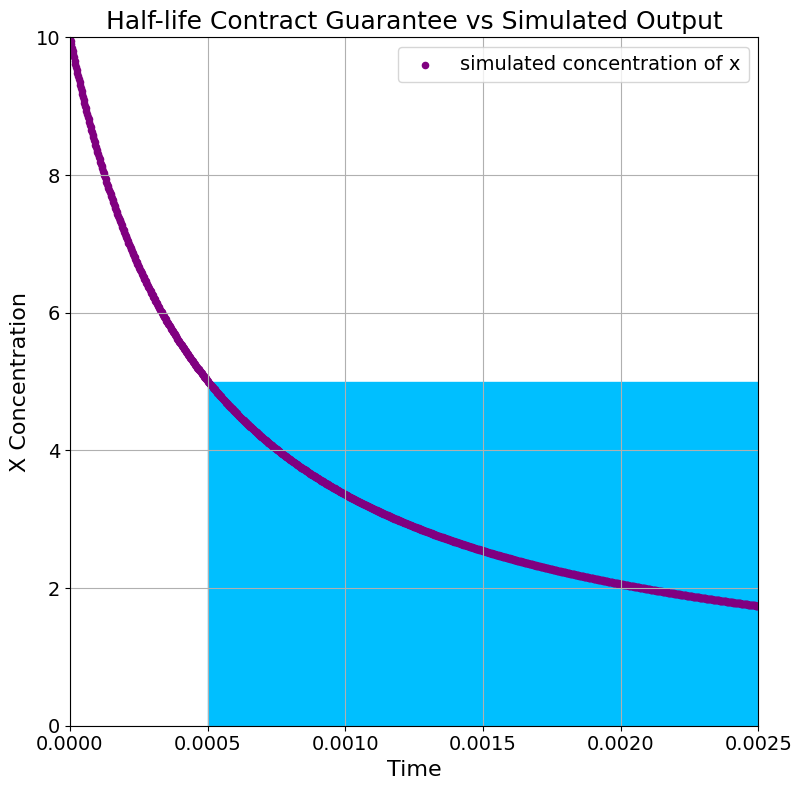

contract2 created:

InVars: [time]
OutVars:[x_output]
A: [
  time <= 0.0005
  -time <= 0
]
G: [
  -x_output <= -5
  x_output <= 10
]


(0.0, 0.0025)

(0.0, 10.0)

Text(0.5, 0, 'Time')

Text(0, 0.5, 'X Concentration')

Text(0.5, 1.0, 'Half-life Contract Guarantee vs Simulated Output')

(array([0.    , 0.0005, 0.001 , 0.0015, 0.002 , 0.0025]),
 [Text(0.0, 0, '0.0000'),
  Text(0.0005, 0, '0.0005'),
  Text(0.001, 0, '0.0010'),
  Text(0.0015, 0, '0.0015'),
  Text(0.002, 0, '0.0020'),
  Text(0.0025, 0, '0.0025')])

(array([ 0.,  2.,  4.,  6.,  8., 10.]),
 [Text(0, 0.0, '0'),
  Text(0, 2.0, '2'),
  Text(0, 4.0, '4'),
  Text(0, 6.0, '6'),
  Text(0, 8.0, '8'),
  Text(0, 10.0, '10')])

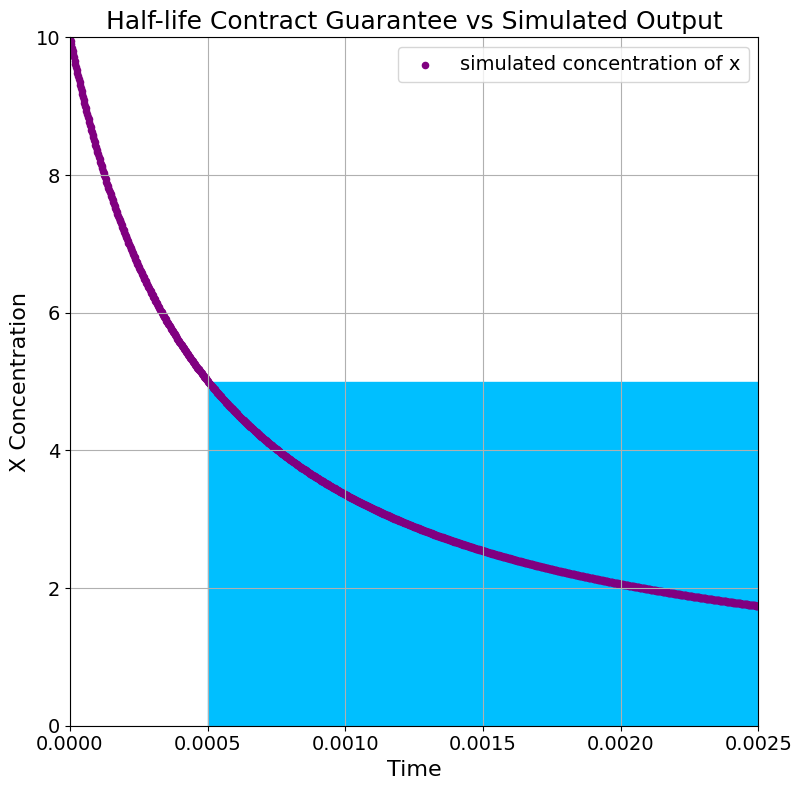

contract successfully saved to contract1.json
contract successfully saved to contract2.json!


In [198]:
from pacti.contracts import PolyhedralIoContract
from pacti.utils.plots import plot_guarantees
from pacti.iocontract import Var
import matplotlib.pyplot as plt
import numpy as np


X_t = np.transpose(np.array(sys.C @ sol))
min_X = X_t.min()
max_X = X_t.max()

timepoints_ode = np.linspace(0, 0.0025, X_t.shape[0])
x_output_data = X_t[:, 0]

half_life_x = x_output_data[0] / 2 

closest_idx = np.argmin(np.abs(x_output_data - half_life_x)) 

half_life_time = timepoints_ode[closest_idx]


print(f"min value (concentration) of X during simulation: {min_X}")
print(f"max value (concentration) of X during simulation: {max_X}\n")
print(f"half-life concentration value: {half_life_x}\n")
print(f"half-life time value: {half_life_time}\n")

contract1 = PolyhedralIoContract.from_dict({
    "assumptions": [
        {"coefficients": {"time": -1}, "constant": -0.0005}   
    ],
    "guarantees": [
        {"coefficients": {"x_output": 1}, "constant": 5},       # x_output <= 5
        {"coefficients": {"x_output": -1}, "constant": 0},      # x_output >= 0
        {"coefficients": {"time": -1}, "constant": 0},          # time >= 0
        {"coefficients": {"time": 1}, "constant": 0.0025}       # time <= 0.0025
    ],
    "input_vars": ["time"],
    "output_vars": ["x_output"]
})  

contract2 = PolyhedralIoContract.from_dict({
    "assumptions": [
        {"coefficients": {"time": 1}, "constant": 0.0005},  # time <= 0.0005
        {"coefficients": {"time": -1}, "constant": 0}      # time >= 0
    ],
    "guarantees": [
        {"coefficients": {"x_output": -1}, "constant": -5},  # x_output >= 5
        {"coefficients": {"x_output": 1}, "constant": 10}    # x_output <= 10
    ],
    "input_vars": ["time"],
    "output_vars": ["x_output"]
})



print("contrac1 created:\n")
print(contract1)

#plot guarantees 

fig = plot_guarantees(
    contract=contract1,
    x_var=Var("time"),
    y_var=Var("x_output"),
    var_values={},
    x_lims=(0, 0.0025),
    y_lims=(0, 10)
)

fig.set_size_inches(10, 8)

# Add the scatter plot with visible size
plt.scatter(timepoints_ode, x_output_data, color="purple", label="simulated concentration of x", s=20)

# Optional: fine-tune the view window to match contract 2
plt.xlim(0, 0.0025)
plt.ylim(0, 10)

# Labels and styling
plt.xlabel("Time", fontsize=16)
plt.ylabel("X Concentration", fontsize=16)
plt.title("Half-life Contract Guarantee vs Simulated Output", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


print("contract2 created:\n")
print(contract2)

fig = plot_guarantees(
    contract=contract1,
    x_var=Var("time"),
    y_var=Var("x_output"),
    var_values={},
    x_lims=(0, 0.0025),
    y_lims=(0, 10)
)

fig.set_size_inches(10, 8)

# Add the scatter plot with visible size
plt.scatter(timepoints_ode, x_output_data, color="purple", label="simulated concentration of x", s=20)

# Optional: fine-tune the view window to match contract 2
plt.xlim(0, 0.0025)
plt.ylim(0, 10)

# Labels and styling
plt.xlabel("Time", fontsize=16)
plt.ylabel("X Concentration", fontsize=16)
plt.title("Half-life Contract Guarantee vs Simulated Output", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


import json

#contract dump
with open("contract1.json", "w") as f:
    json.dump(contract1.to_machine_dict(), f, indent=4)

print("contract successfully saved to contract1.json")

with open("contract2.json", "w") as f: 
    json.dump(contract2.to_machine_dict(),f, indent =4) 

print("contract successfully saved to contract2.json!")